# Workshop - Structural Identifiability
## Erythroblast Growth Inhibition

In [39]:
!pip install casadi scipy tqdm --quiet

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from scipy.interpolate import interp1d
from numpy.linalg import svd
import casadi as ca
from concurrent.futures import ProcessPoolExecutor
import pandas as pd

### Model Configuration

In [ ]:
# === Model configuration for Cell Growth in a Bioreactor Setup ===
nx = 3           # Number of state variables - all states are observed
                 # [0] Biomass Concentration
                 # [1] Inhibitor Concentration
                 # [2] Phi = exp(a * I)
ny = 1           # Number of outputs (observed variables)                 
nth = 4          # Number of parameters used in the model
Tf = 36         # Final integration time [h], based on experimental data duration
Nt = 101         # Number of time evaluation points (can match number of data points or be higher)
t_eval = np.linspace(0, Tf, Nt)  # Time vector for integration

# === Symbolic variables for states and parameters ===
x = ca.MX.sym("x", nx)         # State vector: [X, I, Phi]
theta = ca.MX.sym("theta", nth)

# === Unpack parameters ===
r_g, r_d, a, b = theta[0], theta[1], theta[2], theta[3]

# === Algebraic equations ===
r_ab = np.exp(-a * b)

# === Model definition ===
xdot = ca.vertcat(
    (r_g * x[0])/(1 + r_ab * x[2]),                                       # x[0] Cells concentration
    (r_g * x[0])/(1 + r_ab * x[2]) - r_d*x[1],                            # x[1] Inhibitor concentration
    x[2] * a * (((r_g*x[0])/(1 + r_ab*x[2])) - r_d*x[1])                  # x[2] Phi = exp(a * I)
)

# === Initial conditions as parameters (optional) ===
# You may keep these external, or define them as part of optimization later.
x0 = ca.MX.sym("x0", nx)

# === Nominal parameter values  ===
# r_g, r_d, a, b
theta_nom = np.array([0.057, 0.005, 2.6, 3.4])

# === Fixed initial conditions ===
# Variables:        X    , I  , phi
x0_val = np.array([4.45e6, 0e6, 1]) 
dx0_val = np.zeros((nx, nth))  # Sensitivities of x0 w.r.t. theta are zero

# === Symbolic derivatives for extended system ===
# These Jacobians define the structure of the sensitivity dynamics

dfdx = ca.jacobian(xdot, x)        # ∂f/∂x → state Jacobian
dfdth = ca.jacobian(xdot, theta)   # ∂f/∂θ → parameter Jacobian
dx0dth = ca.jacobian(x0, theta)    # ∂x₀/∂θ → initial sensitivity matrix

# === CasADi function wrappers ===
# These functions allow efficient numerical evaluation of the model and its derivatives

f = ca.Function("f", [x, theta], [xdot])                 # System dynamics
dfdx_fun = ca.Function("dfdx", [x, theta], [dfdx])       # Jacobian ∂f/∂x
dfdth_fun = ca.Function("dfdth", [x, theta], [dfdth])    # Jacobian ∂f/∂θ
dx0dth_fun = ca.Function("dx0dth", [theta], [dx0dth])    # ∂x₀/∂θ sensitivity matrix

# === Extended system: sensitivity ODEs ===
# Implements d(xθ)/dt = (∂f/∂x)·xθ + ∂f/∂θ
# Solves both the original system and the sensitivity dynamics

def meta_rhs(t, x_ext, theta_val):
    x = x_ext[:nx]
    dx_dth = x_ext[nx:].reshape((nx, nth))
    A = np.array(dfdx_fun(x, theta_val))        # ∂f/∂x evaluated at current state
    B = np.array(dfdth_fun(x, theta_val))       # ∂f/∂θ evaluated at current state
    dx = np.array(f(x, theta_val)).flatten()    # dx/dt
    d_dx_dth = A @ dx_dth + B                   # d(∂x/∂θ)/dt
    return np.concatenate([dx, d_dx_dth.flatten()])

# === Forward integration of state and sensitivities ===
# Solves the extended system using initial state and initial sensitivities

def simulate_once(theta_val):
    x0_val = np.array([4.45e6, 0e6, 1])                                   # Initial state x₀(θ)
    dx0_val = np.zeros((nx, nth))                                         # Initial ∂x₀/∂θ
    x0_ext = np.concatenate([x0_val, dx0_val.flatten()])                  # Extended initial condition
    sol = solve_ivp(lambda t, x: meta_rhs(t, x, theta_val),
                t_span=(0, Tf), y0=x0_ext, method="BDF",
                rtol=1e-9, atol=1e-9, dense_output=True)
    y_dense = sol.sol(t_eval)
    x_out = y_dense[:nx, :].T
    dx_dth_out = y_dense[nx:, :].T.reshape(Nt, nx, nth)
    return t_eval, x_out, dx_dth_out

# === Sensitivity matrix computation (output) ===
# Implements: yθ = (∂h/∂x)·xθ + ∂h/∂θ
# In this model, h(x) = x₁(t), so ∂h/∂x = [1, 0] and ∂h/∂θ = 0

def compute_dydth(x_out, dx_dth_out, theta_val):

    # OSM: Output Sensitivity Matrix → dydth[i, j] = ∂y(t_i)/∂θ_j
    dydth = np.zeros((Nt * ny, nth))

    # ROSM: Relative Output Sensitivity Matrix → dydth_rel[i, j] = (∂y/∂θ)(θ_j / y(t))
    dydth_rel = np.zeros_like(dydth)

    # Store output values for optional plotting or normalization
    y_out = np.zeros((Nt, ny))

    for i in range(Nt):
        x_i = x_out[i]
        dx_i = dx_dth_out[i]
        for j in range(ny):
            y_out[i, j] = x_i[j]
            dydth_i = dx_i[j, :]
            dydth[i * ny + j] = dydth_i
            if x_i[j] != 0:
                dydth_rel[i * ny + j] = dydth_i * theta_val / x_i[j]
            else:
                dydth_rel[i * ny + j] = dydth_i * theta_val / np.mean(y_out[:, j])
    return dydth, dydth_rel, y_out


In [42]:
# === SVD ===
t_eval, x_out, dx_dth_out = simulate_once(theta_nom)
dydth, dydth_rel, y_out = compute_dydth(x_out, dx_dth_out, theta_nom)
U, S, Vh = svd(dydth_rel, full_matrices=False)

In [43]:
# === Monte Carlo sensitivity analysis ===
# Sample parameter vectors around the nominal values
NExp = 100
#                       r_g   r_d     a      b
theta_low = np.array([0.048, 0.011, 6.804, 3.609])
theta_high = np.array([0.050, 0.015, theta_nom[3]*1.5, 3.894])

In [44]:
THETA = np.random.uniform(theta_low, theta_high, size=(NExp, nth))
THETA[0] = theta_nom  # Ensure nominal parameters are included

# Start CPU time measurement
start_time = time.perf_counter()

# Storage arrays for singular values and nullspace vectors
SingularValues_list = []
V_last_cols_list = []

for k in range(NExp):
    theta_k = THETA[k]
    t_out, x_out, dx_dth_out = simulate_once(theta_k)
    dydth, dydth_rel, _ = compute_dydth(x_out, dx_dth_out, theta_k)

    U, S, Vh = svd(dydth_rel, full_matrices=False)
    if S.shape[0] == nth:
        SingularValues_list.append(S)
        V_last_cols_list.append(Vh[-1])
    else:
        print(f"Saltando experimento {k} por tamaño incorrecto: {S.shape}")

SingularValues = np.array(SingularValues_list)
V_last_cols = np.array(V_last_cols_list).T  # transpuesta para mantener forma (nth, Nvalid)


# End CPU time measurement
elapsed_time = time.perf_counter() - start_time
avg_time_per_exp = elapsed_time / NExp

print(f"Monte Carlo analysis completed in {elapsed_time:.2f} seconds.")
print(f"Average time per experiment: {avg_time_per_exp:.2f} seconds.")

Monte Carlo analysis completed in 109.05 seconds.
Average time per experiment: 1.09 seconds.


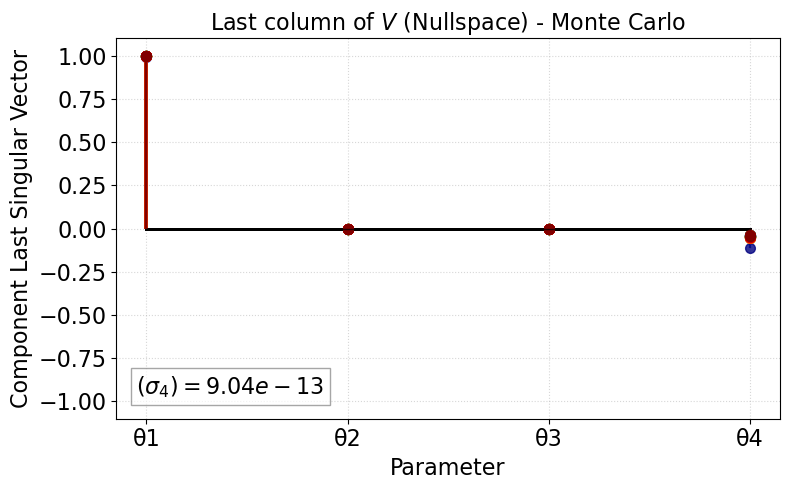

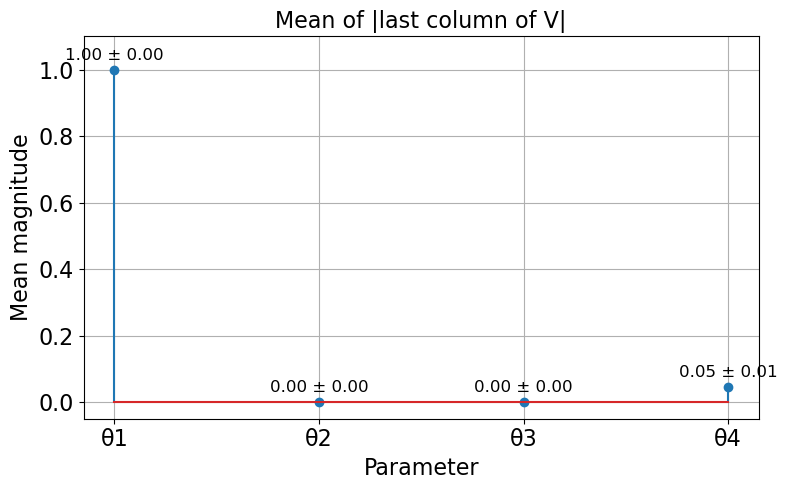

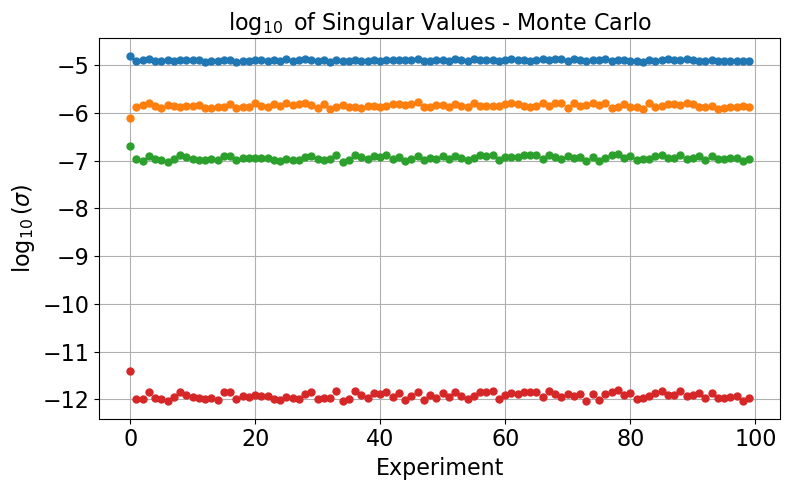


=== Fixing Analysis from Nullspace ===
Contribution threshold: |v_i| > 0.30
Parameters with strong contribution (candidates):
 - θ1: |v_i| ≈ 1.00


In [45]:
# Compute mean and standard deviation of nullspace components
mean_v = np.mean(np.abs(V_last_cols), axis=1)
std_v = np.std(np.abs(V_last_cols), axis=1)
min_sigma = np.min(SingularValues[:, -1])
max_sigma = np.max(SingularValues[:, 0])

# === Plot: Last column of V for each experiment ===
param_names = [f"θ{i+1}" for i in range(nth)]
x_vals = np.arange(nth)
colors = plt.cm.jet(np.linspace(0, 1, NExp))

plt.figure(figsize=(8, 5))
for k in range(NExp):
    v_last = V_last_cols[:, k]
    markerline, stemlines, baseline = plt.stem(
        x_vals, v_last,
        linefmt='-', markerfmt='o', basefmt='k-',
        label=f'Exp {k+1}'
    )
    plt.setp(markerline, color=colors[k], markersize=7, alpha=0.8)
    plt.setp(stemlines, color=colors[k], linewidth=1.6, alpha=0.8)
    plt.setp(baseline, color='k', linewidth=1.0, alpha=0.7)

plt.xticks(x_vals, param_names, rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.title(r"Last column of $V$ (Nullspace) - Monte Carlo", fontsize=16)
plt.xlabel("Parameter", fontsize=16)
plt.ylabel(r"Component Last Singular Vector", fontsize=16)
plt.ylim(-1.1, 1.1)
plt.grid(True, linestyle=':', alpha=0.5)

plt.text(
    0.03, 0.05,
    rf'$(\sigma_{{{nth}}}) = {min_sigma:.2e}$',
    fontsize=16,
    transform=plt.gca().transAxes,
    ha='left', va='bottom',
    bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7)
)

plt.tight_layout()
plt.show()

# === Plot: Mean of |last column of V| ===
plt.figure(figsize=(8, 5))
plt.stem(mean_v)
plt.xticks(x_vals, param_names, rotation=0, fontsize=16)
plt.yticks(fontsize=16)
for i in range(nth):
    plt.text(i, mean_v[i] + 0.02, f"{mean_v[i]:.2f} ± {std_v[i]:.2f}", ha='center', va='bottom', fontsize=12)

plt.title("Mean of |last column of V|", fontsize=16)
plt.xlabel("Parameter", fontsize=16)
plt.ylabel("Mean magnitude", fontsize=16)
plt.ylim(-0.05, 1.1)
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot: log10 of singular values across experiments ===
plt.figure(figsize=(8, 5))
plt.plot(np.log10(SingularValues), '.', markersize=10)
plt.title(r"$\log_{10}$ of Singular Values - Monte Carlo", fontsize=16)
plt.xlabel("Experiment", fontsize=16)
plt.ylabel(r"$\log_{10}(\sigma)$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Fixed Parameters Analysis from last column of V (Nullspace) ---

# Threshold for "strong" contribution in the nullspace vector
umbral_contribucion = 0.3

# Last column of mean V, already calculated by Monte Carlo (mean over |last V| per experiment)
# Assuming mean_v = np.mean(np.abs(V_last_cols), axis=1)
last_V_abs = mean_v  # Vector with absolute contributions averaged over experiments


# Parameters indexes with strong contribution
indices_candidatos = np.where(last_V_abs > umbral_contribucion)[0]
param_candidatos = [param_names[i] for i in indices_candidatos]

# Analysis of parameters candidates for fixing
print("\n=== Fixing Analysis from Nullspace ===")
print(f"Contribution threshold: |v_i| > {umbral_contribucion:.2f}")
print("Parameters with strong contribution (candidates):")
for i in indices_candidatos:
    print(f" - {param_names[i]}: |v_i| ≈ {last_V_abs[i]:.2f}")

if len(indices_candidatos) == 0:
    print(" There's no parameters with sufficiently high contribution to suggest fixing.")

## Simulation vs Experimental Data

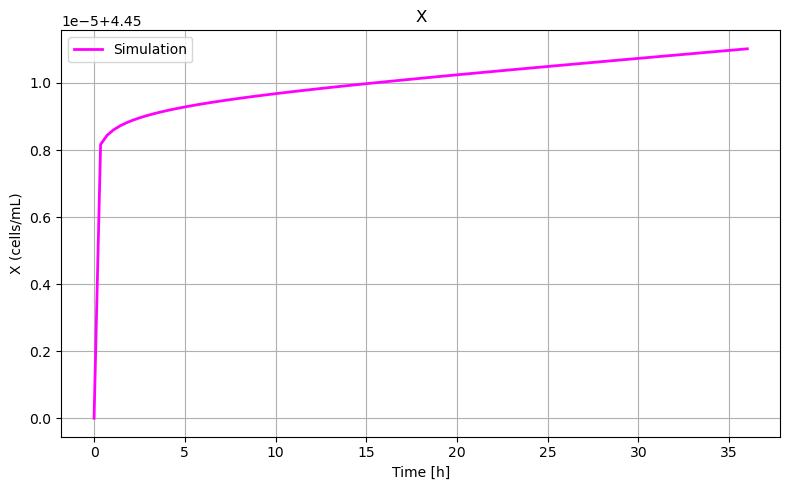

In [46]:
t_out, x_out, dx_dth_out = simulate_once(theta_nom)
observed_indices = [0]
observed_labels = ['X']
units = 'cells/mL'  

# Convertir resultados a mg/g.s.i.
_, _, y_out = compute_dydth(x_out, dx_dth_out, theta_nom)


# Plot 3x2 estilo HIPPO con unidades corregidas
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))  # Un solo eje

# Supongamos que quieres graficar la primera variable (índice 0)
i = 0
ax.plot(t_out, y_out[:, i]*1e-6, color='magenta', linewidth=2, label='Simulation')
ax.set_title(observed_labels[i])
ax.set_xlabel("Time [h]")
ax.set_ylabel(f"{observed_labels[i]} ({units})")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


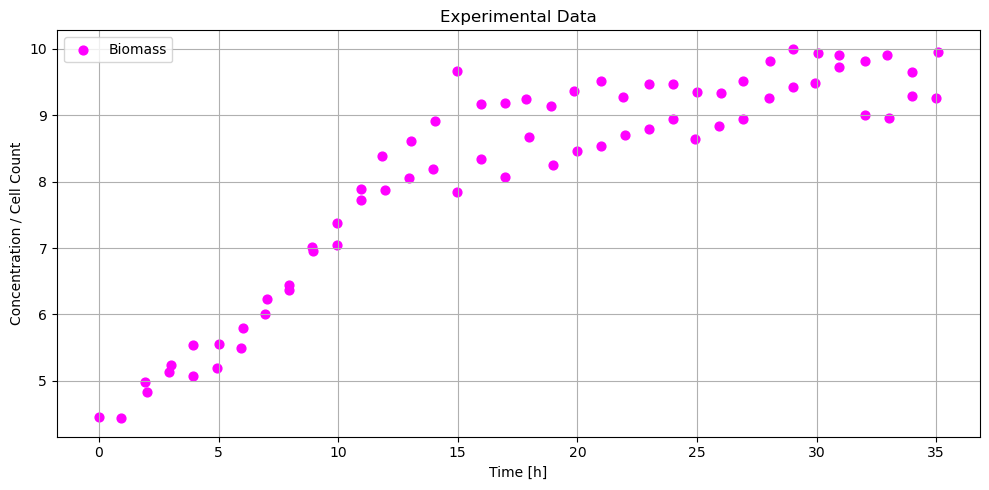

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Leer archivo
data_file = 'Model3Data.csv'
df = pd.read_csv(data_file, sep=',', header = 0)
df.columns = ["Time", "X"]
df = df.astype(float)

# Extraer variables
t_exp      = df["Time"].to_numpy()
biomass    = df["X"].to_numpy()

fig, ax = plt.subplots(figsize=(10, 5))  # Un solo eje

# Graficar las tres variables experimentales en un mismo eje
ax.scatter(t_exp, biomass, color='magenta', label="Biomass", s=40)

ax.set_xlabel("Time [h]")
ax.set_ylabel("Concentration / Cell Count")
ax.set_title("Experimental Data")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()
